In [7]:
import findspark
findspark.init("/home/raj/spark/")

In [10]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
import numpy as np
from pandas import *
from ggplot import *
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

def Linear_regression_ggplot():
    

    spark = SparkSession \
        .builder \
        .appName("LinearRegression") \
        .getOrCreate()


    data = spark.read.format("csv")\
      .option("header", "true")\
      .option("inferSchema", "true")\
      .load("/home/raj/Videos/samdata/ml_folder/linear_regression/export.csv")
    data.cache()  # Cache data for faster reuse
    data.count()
#data.show()
#data.printSchema()

    data.createOrReplaceTempView("data_geo")
    df = spark.sql("select popest2014, median2015 as label from data_geo")
#df.show()
    

    assembler = VectorAssembler(
        inputCols=["popest2014"],
        outputCol="features")
    output = assembler.transform(df)



# Define LinearRegression algorithm
    lr = LinearRegression()

# Fit 2 models, using different regularization parameters
    modelA = lr.fit(output, {lr.regParam:0.0})
    modelB = lr.fit(output, {lr.regParam:100.0})

    print(">>>> ModelA intercept: %r, coefficient: %r" % (modelA.intercept, modelA.coefficients[0]))

    print(">>>> ModelB intercept: %r, coefficient: %r" % (modelB.intercept, modelB.coefficients[0]))

    predictionsA = modelA.transform(output)

    predictionsB = modelB.transform(output)

    
    evaluator = RegressionEvaluator(metricName="rmse")
    RMSE = evaluator.evaluate(predictionsA)
    print("ModelA: Root Mean Squared Error = " + str(RMSE))

    pop = [i.features[0] for i in output.select("features").collect()]
    price = [i.label for i in output.select("label").collect()]

    predA = [i for i in predictionsA.select("prediction").collect()]
    predB = [i for i in  predictionsB.select("prediction").collect()]
#print predA
#print predB
#print pop
#print price

    pydf = DataFrame({'pop':pop,'price':price,'predA':predA, 'predB':predB})

    p = ggplot(pydf, aes('pop','price')) + \
        geom_point(color='blue') + \
        geom_line(pydf, aes('pop','predA'), color='red') + \
        geom_line(pydf, aes('pop','predB'), color='green')
    
    print(p)
    
    return predA , predB

>>>> ModelA intercept: 191.29427575139394, coefficient: 3.779789682338248e-05
>>>> ModelB intercept: 199.85112564667153, coefficient: 2.1603499483717156e-05
ModelA: Root Mean Squared Error = 128.60202684284758


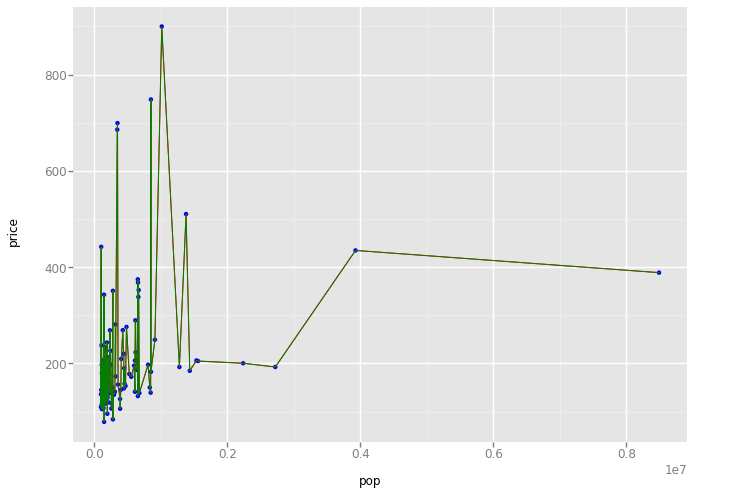

<ggplot: (8761713835528)>


([Row(prediction=199.3167659584664),
  Row(prediction=198.40882267887193),
  Row(prediction=198.65258131548592),
  Row(prediction=198.87203590444247),
  Row(prediction=249.39183544694856),
  Row(prediction=211.25050693302884),
  Row(prediction=198.7671467407576),
  Row(prediction=204.4100325554172),
  Row(prediction=339.79707185649573),
  Row(prediction=203.37085497805194),
  Row(prediction=209.63377749220228),
  Row(prediction=243.49577931936597),
  Row(prediction=223.51581105852597),
  Row(prediction=229.6888123761335),
  Row(prediction=195.26728828229332),
  Row(prediction=208.14571209216254),
  Row(prediction=216.3868631323583),
  Row(prediction=196.87369889728708),
  Row(prediction=196.00786247475386),
  Row(prediction=196.21866134533786),
  Row(prediction=216.1990453830429),
  Row(prediction=197.71439971843276),
  Row(prediction=196.14979357732565),
  Row(prediction=223.55032053832574),
  Row(prediction=195.16273929967986),
  Row(prediction=207.55992028719376),
  Row(prediction=1

In [11]:
Linear_regression_ggplot()